In [20]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [21]:
pl.style.use('fabiostyle')
pl.rcParams['pdf.fonttype']=42
pl.rcParams['ps.fonttype']=42
# needs to find the library of functions
sys.path.append('../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [22]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_vs_baseline_FIGURES'

In [23]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [24]:
# use `save_worspace(db)` to save variables at the end
pl.rcParams['pdf.fonttype']=42
pl.rcParams['ps.fonttype']=42

In [25]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [26]:
#mmc = multiple-comparisons correction (using bonferroni), where mcc = number of comparisons))

from matplotlib.lines import Line2D
def add_significance(ax, array1, array2, x1, x2, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),mcc=1,suppress_ns=True):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    elif sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_ind(x,y)
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    if suppress_ns==True:
        if p <= thresholds[0]/mcc:
            line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
            ax.add_line(line)
            ax.text(np.mean([x1, x2]), y,
                    '*' if p > thresholds[1]/mcc else
                    '**' if p > thresholds[2]/mcc else
                    '***',
                    ha='center', fontsize=5)
    else:
        line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
        ax.add_line(line)
        ax.text(np.mean([x1, x2]), y+1,
            'n.s.' if p > thresholds[0]/mcc else
            '*' if p > thresholds[1]/mcc else
            '**' if p > thresholds[2]/mcc else
            '***',
            ha='center', fontsize=5)
    return sig_value, p

In [27]:
#mmc = multiple-comparisons correction (using bonferroni), where mcc = number of comparisons))

from matplotlib.lines import Line2D
def add_significance_point(ax, array1, array2, x1, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),
                                   mcc=1,color='k',symbol='*'):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    elif sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    #line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
    #ax.add_line(line)
    ax.text(x1, y,
            "" if p > thresholds[0]/mcc else
            symbol if p > thresholds[1]/mcc else
            symbol+symbol if p > thresholds[2]/mcc else
            symbol+symbol+symbol,
            #symbol if p < thresholds[1]/mcc else
            #"",
            ha='center', fontsize=5,color=color)
    return sig_value, p

In [28]:
def report_stats (array1, array2, sig_func=None,mcc=1):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
        U = sig_func(array1, array2)[0]
        z = ((U-((loops*loops)/2))/(np.sqrt(((loops*loops)*(loops+loops+1))/12)))
        r = z/np.sqrt(loops*2)
        p = sig_func(array1, array2)[-1]
        print "U =",U,"p =",p*mcc,"r =",r
    if sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_ind(x, y)
        cohens_d = (np.mean(array1)-np.mean(array2))/np.sqrt((np.std(array1)**2+np.std(array2)**2)/2)
        p = sig_func(array1, array2)[-1]
        print sig_func(array1, array2),"d =", cohens_d, 'corrected p =',p*mcc
    if sig_func is 'fishers':
        table = array1,array2
        sig_func = lambda x: sstats.fisher_exact(x, alternative='two-sided')
        p = sig_func(table)[-1]
        odds_ratio = sig_func(table)[0]
        print sig_func(table),"odd's ratio =", odds_ratio, 'corrected p =',p*mcc
        

def report_stats_chance (array1, chance=0.5, sig_func=None,mcc=1):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        U = sig_func(subtracted)[0]
        z = ((U-((loops*loops)/2))/(np.sqrt(((loops*loops)*(loops+loops+1))/12)))
        r = z/np.sqrt(loops*2)
        print sig_func(subtracted),"r =",r
    elif sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        cohens_d = (np.mean(array1)-chance)/np.std(array1)
        print sig_func(array1,chance),"d =",cohens_d

In [29]:
loops=10

In [30]:
def sig_vs_chance(ax, array1, chance, x1, y1, loops=loops, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),colors='k'):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        p = sig_func(subtracted)[-1]
        sig_value = sig_func(subtracted)[0]
    elif sig_func is ttest:
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        p = sig_func(array1,chance)[-1]
        sig_value = sig_func(array1,chance)[0]
    ax.text(x1, y1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4, color=colors)
    return sig_value, p

In [31]:
delta_t05s = 0.5
t_start05s = -3
t_stop05s  = 11.5

delta_t1s = 1
t_start1s = -3  # sec
t_stop1s  = 11  # sec

delta_t2s = 2
t_start2s = -2
t_stop2s  = 10

#1sec time bins centered on the half-second
delta_t15s = 1
t_start15s = -3.5  # sec
t_stop15s = 10.5  # sec

In [32]:
sessions = 'post',
bins = ['05s','1s','2s']
bin_ranges=[]
for tb in bins:
    if tb == '05s':
        div=0.5
    else:
        div=tb[:-1]
            #print range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
    #for t in range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div)))):
    bin_ranges.append(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
print bin_ranges

[29, 14, 6]


In [33]:
#trial type labels:
#reward w/o eliciting sucrose = 1, rew eliciting reward but not collecting within 1.5s of delivery=+ = 4, rew w/ consumption = 5
#CSm w/o running > threshold= 2, CSm w/ running > threshold = 6
#AA shocked= 3, AA avoided shock (running > threshold) = 7

In [34]:
#time bins for each tb delta to use for baseline (05s starts at -2s, 1s at -2s, 2s at -2s)

In [36]:
#import results from notebooks
comparison_labels='still_rew','still_CSm','still_AA','not_consumed','consumed','run_CSm','run_AA'
for tb,i in zip(bins,range(len(bins))):
    for t in range(bin_ranges[i]): # number of time bins
        for comp_la in comparison_labels:
            for reg in 'dhpc','vhpc':
                try:
                    exec("baseline_scores_gmin_%s_%s_%s_%s = {}"%(tb,t,comp_la,reg))
                    exec("baseline_scores_speed_%s_%s_%s_%s = {}"%(tb,t,comp_la,reg))
                    for sess in 'post',:
                        exec("baseline_scores_gmin_%s_%s_%s_%s = ut.load_variable\
                              ('baseline_scores_gmin_%s_%s_%s','../notebooks/autorestore/decoding_vs_baseline_%s')"\
                              %(tb,t,comp_la,reg,tb,t,comp_la,reg))
                        exec("baseline_scores_speed_%s_%s_%s_%s = ut.load_variable\
                              ('baseline_scores_speed_%s_%s_%s','../notebooks/autorestore/decoding_vs_baseline_%s')"\
                              %(tb,t,comp_la,reg,tb,t,comp_la,reg))
                except:
                    print 'Nope',comp_la,reg

Nope still_rew dhpc
Nope still_rew vhpc
Nope still_CSm dhpc
Nope still_CSm vhpc
Nope still_AA dhpc
Nope still_AA vhpc
Nope not_consumed dhpc
Nope not_consumed vhpc
Nope still_rew dhpc
Nope still_rew vhpc
Nope still_CSm dhpc
Nope still_CSm vhpc
Nope still_AA dhpc
Nope still_AA vhpc
Nope not_consumed dhpc
Nope not_consumed vhpc
Nope still_rew dhpc
Nope still_rew vhpc
Nope still_CSm dhpc
Nope still_CSm vhpc
Nope still_AA dhpc
Nope still_AA vhpc
Nope not_consumed dhpc
Nope not_consumed vhpc
Nope still_rew dhpc
Nope still_rew vhpc
Nope still_CSm dhpc
Nope still_CSm vhpc
Nope still_AA dhpc
Nope still_AA vhpc
Nope not_consumed dhpc
Nope not_consumed vhpc
Nope still_rew dhpc
Nope still_rew vhpc
Nope still_CSm dhpc
Nope still_CSm vhpc
Nope still_AA dhpc
Nope still_AA vhpc
Nope not_consumed dhpc
Nope not_consumed vhpc
Nope still_rew dhpc
Nope still_rew vhpc
Nope still_CSm dhpc
Nope still_CSm vhpc
Nope still_AA dhpc
Nope still_AA vhpc
Nope not_consumed dhpc
Nope not_consumed vhpc
Nope still_rew d

In [37]:
#I guess no data for not_consumed trials for dhpc, so not including
loops=10
comparison_labels='still_rew','still_CSm','still_AA','consumed','run_CSm','run_AA'
for tb,i in zip(bins,range(len(bins))):
    for t in range(bin_ranges[i]): # number of time bins
        for comp_la in comparison_labels:
            for reg in 'dhpc','vhpc':
                exec("ttest_tb_%s_%s_%s = {}"%(tb,t,comp_la))
                exec("mannwhitU_tb_%s_%s_%s = {}"%(tb,t,comp_la))
                for sess in sessions:
                    exec("ttest_tb_%s_%s_%s[sess] = sstats.ttest_ind(baseline_scores_gmin_%s_%s_%s_dhpc[sess][-loops:],\
                       baseline_scores_gmin_%s_%s_%s_vhpc[sess][-loops:])"%(tb,t,comp_la,tb,t,comp_la,tb,t,comp_la))
                    exec("mannwhitU_tb_%s_%s_%s[sess] = sstats.mannwhitneyu(baseline_scores_gmin_%s_%s_%s_dhpc[sess][-loops:],\
                       baseline_scores_gmin_%s_%s_%s_vhpc[sess][-loops:])"%(tb,t,comp_la,tb,t,comp_la,tb,t,comp_la))

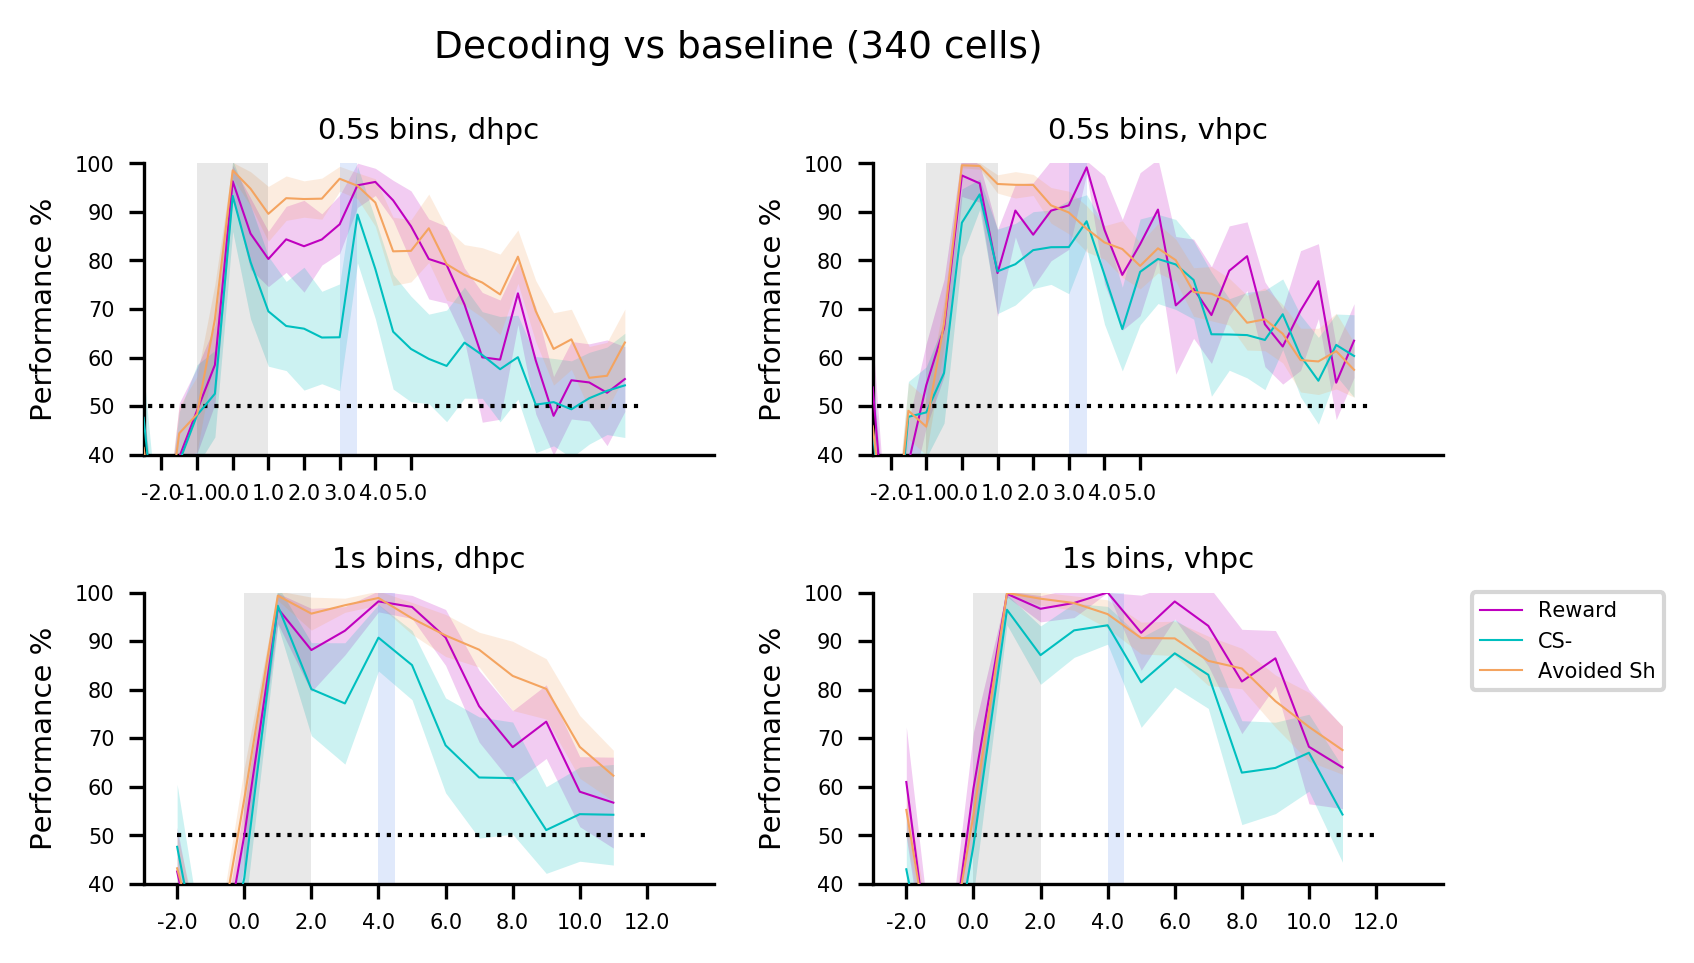

In [42]:
fig, ax = pl.subplots(2,2, figsize=(5,3))

for comp,c,la in zip(['consumed','run_CSm','run_AA'],['m','c','sandybrown'],
                     ['Reward','CS-','Avoided Sh']):
    for r,tb,sub in zip(range(2),bins[:2],[4,2]):
        for y, reg in zip([0,1],['dhpc','vhpc']):
            ax[r][y].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("baseline_scores_gmin_%s_%s_%s_%s['post']"%(tb,t,comp,reg)))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_gmin_%s_%s_%s_%s['post']"%(tb,t,comp,reg)))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("baseline_scores_gmin_%s_%s_%s_%s['post']"%(tb,t,comp,reg)))*100 for t in range(bin_ranges[r])])
            ax[r][y].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x,tick in zip(range(2),[2,1]):
    for y,reg in zip([0,1],['dhpc','vhpc']):
        ax[x][y].set_ylim(40, 100)
        ax[x][y].set_xlim(-3, bin_ranges[x])
        ax[x][y].set_xticks(np.arange(-2,13, 2.0))
        ax[x][y].set_xticklabels(np.arange(-2,13*tick, 2.0/tick))
        ax[x][y].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
        #ax[x][y].set_xlabel('Time from odor onset (s)')
        ax[x][y].set_ylabel('Performance %')
        pt.plot_period_bar(ax[x][y], 0, start_end=(0, 2*tick), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[x][y], 0, start_end=(4*tick, 4.5*tick), color='cornflowerblue', delta_y=100, alpha=.2)
        #ax[x][y].tick_params(
        #axis='x',          # changes apply to the x-axis
        #which='both',      # both major and minor ticks are affected
        #bottom=False,      # ticks along the bottom edge are off
        #top=False,         # ticks along the top edge are off
        #labelbottom=False) # labels along the bottom edge are off
        ax[0][y].set_title('0.5s bins, %s'%reg, color='k')
        ax[1][y].set_title('1s bins, %s'%reg, color = 'k')
        ax[1][1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (340 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

#[y]fig.savefig('../figures/%s_run_gmin.jpg'%NOTEBOOK_NAME)

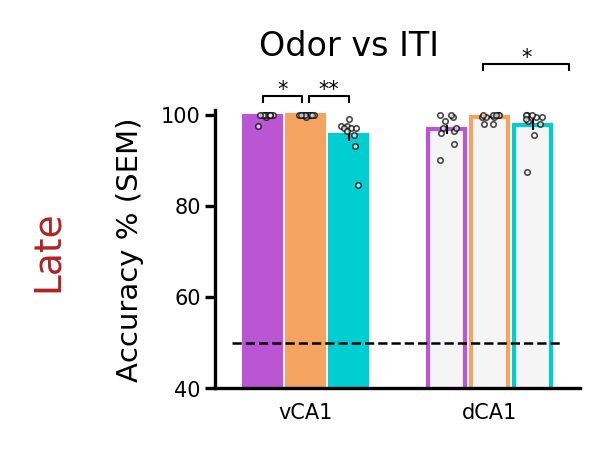

In [39]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars
loops=10
to_plot = [0,1]
t=3
tb='1s'
fig, ax = pl.subplots(figsize=(1.9,1.4))

for comp,c,la,wide in zip(['consumed','run_AA','run_CSm'],['mediumorchid','sandybrown','darkturquoise'],
                     ['Reward','Avoided Sh','CS-'],[-width/3-.25,0,width/3+.25,0.5+.2]):
    ste = np.array(np.std(eval("baseline_scores_gmin_%s_%s_%s_vhpc['post'][-loops:]"%(tb,t,comp)))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("baseline_scores_gmin_%s_%s_%s_vhpc['post'][-loops:]"%(tb,t,comp)))*100,
           width, edgecolor=c,color=c,yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, eval("baseline_scores_gmin_%s_%s_%s_vhpc['post'][-loops:]"%(tb,t,comp))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
    
for comp,c,la,wide in zip(['consumed','run_AA','run_CSm'],['mediumorchid','sandybrown','darkturquoise'],
                     ['Reward','Avoided Sh','CS-'],[1.5+-width/3-.25,1.5+0,1.5+width/3+.25,1.5+0.5+.2]):
    ste = np.array(np.std(eval("baseline_scores_gmin_%s_%s_%s_dhpc['post'][-loops:]"%(tb,t,comp)))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("baseline_scores_gmin_%s_%s_%s_dhpc['post'][-loops:]"%(tb,t,comp)))*100,
           width, edgecolor=c,color='whitesmoke',yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, eval("baseline_scores_gmin_%s_%s_%s_dhpc['post'][-loops:]"%(tb,t,comp))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')

ax.hlines(50,-.6,2.1, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)')
#ax.set_title('Decoding During CS')
ax.set_ylim(40,101)
ax.set_xticks([0,1.5])
ax.set_xticklabels(labels)
#ax.legend([Patch(facecolor='darkorchid'),Patch(facecolor='sandybrown'),Patch(facecolor='darkturquoise')],
#          ['Rew','Shock','CS-'],loc=(.95,.6),frameon=False)
#ax.text(2.8,92,'Rew',color='mediumorchid',fontsize=5.5)
#ax.text(2.8,80,'CS-',color='darkturquoise',fontsize=5.5)
#ax.text(2.8,86,'Avoided Shock',color='sandybrown',fontsize=5.5)
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
pvs=[]
test='ttest'
for reg,i in zip(['vhpc','dhpc'], [0,1.8]):
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_consumed_%s['post'][-loops:]"%(tb,t,reg)),
                                eval("baseline_scores_gmin_%s_%s_run_CSm_%s['post'][-loops:]"%(tb,t,reg)),
                                -width/3-.25+i,i-.03,104,sig_func=test,mcc=2))
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_run_CSm_%s['post'][-loops:]"%(tb,t,reg)),
                                eval("baseline_scores_gmin_%s_%s_run_AA_%s['post'][-loops:]"%(tb,t,reg)),
        i+.03,width/3+.25+i,104,sig_func=test,mcc=2))
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_consumed_%s['post'][-loops:]"%(tb,t,reg)),
                                eval("baseline_scores_gmin_%s_%s_run_AA_%s['post'][-loops:]"%(tb,t,reg)),
        -width/3-.25+i,width/3+.25+i,111,sig_func=test,mcc=2))
    #print reg,'rw/sh',report_stats(eval("baseline_scores_tb_4_rw_%s['post'][-loops:]"%reg), eval("baseline_scores_tb_4_sh_%s['post'][-loops:]"%reg),mcc=2)
    #print reg,'rw/CS-',report_stats(eval("baseline_scores_tb_4_rw_%s['post'][-loops:]"%reg), eval("baseline_scores_tb_4_csm_%s['post'][-loops:]"%reg),mcc=2)
    #print reg,'sh/CS-',report_stats(eval("baseline_scores_tb_4_sh_%s['post'][-loops:]"%reg), eval("baseline_scores_tb_4_csm_%s['post'][-loops:]"%reg),mcc=2)

pl.suptitle('Odor vs ITI',y=1.06,fontsize=8)
ax.text(-2.1,70,'Late',rotation=90,fontsize=9,color='firebrick',ha='center',va='center')
fig.tight_layout(pad=2.5)

fig.savefig('../figures/%s_bars_odor.pdf'%NOTEBOOK_NAME)

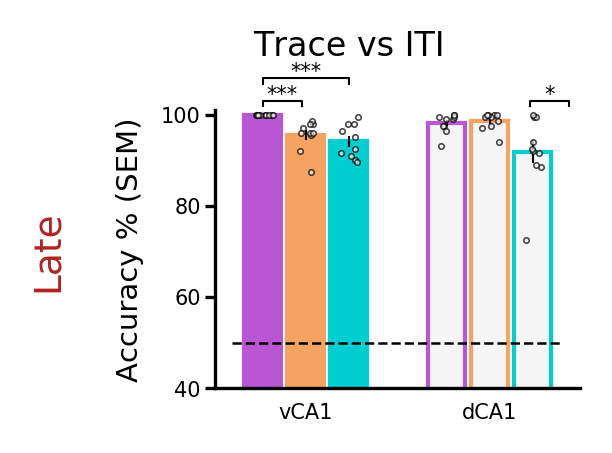

In [40]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars
loops=10
to_plot = [0,1]
t=6
tb='1s'
fig, ax = pl.subplots(figsize=(1.9,1.4))

for comp,c,la,wide in zip(['consumed','run_AA','run_CSm'],['mediumorchid','sandybrown','darkturquoise'],
                     ['Reward','Avoided Sh','CS-'],[-width/3-.25,0,width/3+.25,0.5+.2]):
    ste = np.array(np.std(eval("baseline_scores_gmin_%s_%s_%s_vhpc['post'][-loops:]"%(tb,t,comp)))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("baseline_scores_gmin_%s_%s_%s_vhpc['post'][-loops:]"%(tb,t,comp)))*100,
           width, edgecolor=c,color=c,yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, eval("baseline_scores_gmin_%s_%s_%s_vhpc['post'][-loops:]"%(tb,t,comp))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
    
for comp,c,la,wide in zip(['consumed','run_AA','run_CSm'],['mediumorchid','sandybrown','darkturquoise'],
                     ['Reward','Avoided Sh','CS-'],[1.5+-width/3-.25,1.5+0,1.5+width/3+.25,1.5+0.5+.2]):
    ste = np.array(np.std(eval("baseline_scores_gmin_%s_%s_%s_dhpc['post'][-loops:]"%(tb,t,comp)))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("baseline_scores_gmin_%s_%s_%s_dhpc['post'][-loops:]"%(tb,t,comp)))*100,
           width, edgecolor=c,color='whitesmoke',yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, eval("baseline_scores_gmin_%s_%s_%s_dhpc['post'][-loops:]"%(tb,t,comp))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')

ax.hlines(50,-.6,2.1, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)')
#ax.set_title('Decoding During CS')
ax.set_ylim(40,101)
ax.set_xticks([0,1.5])
ax.set_xticklabels(labels)
#ax.legend([Patch(facecolor='darkorchid'),Patch(facecolor='sandybrown'),Patch(facecolor='darkturquoise')],
#          ['Rew','Shock','CS-'],loc=(.95,.6),frameon=False)
#ax.text(2.8,92,'Rew',color='mediumorchid',fontsize=5.5)
#ax.text(2.8,80,'CS-',color='darkturquoise',fontsize=5.5)
#ax.text(2.8,86,'Avoided Shock',color='sandybrown',fontsize=5.5)
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
pvs=[]
test='ttest'
for reg,i in zip(['vhpc','dhpc'], [0,1.8]):
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_consumed_%s['post'][-loops:]"%(tb,t,reg)),
                                eval("baseline_scores_gmin_%s_%s_run_CSm_%s['post'][-loops:]"%(tb,t,reg)),
                                -width/3-.25+i,i-.03,103,sig_func=test,mcc=2))
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_run_CSm_%s['post'][-loops:]"%(tb,t,reg)),
                                eval("baseline_scores_gmin_%s_%s_run_AA_%s['post'][-loops:]"%(tb,t,reg)),
        i+.03,width/3+.25+i,103,sig_func=test,mcc=2))
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_consumed_%s['post'][-loops:]"%(tb,t,reg)),
                                eval("baseline_scores_gmin_%s_%s_run_AA_%s['post'][-loops:]"%(tb,t,reg)),
        -width/3-.25+i,width/3+.25+i,108,sig_func=test,mcc=2))
    #print reg,'rw/sh',report_stats(eval("baseline_scores_tb_4_rw_%s['post'][-loops:]"%reg), eval("baseline_scores_tb_4_sh_%s['post'][-loops:]"%reg),mcc=2)
    #print reg,'rw/CS-',report_stats(eval("baseline_scores_tb_4_rw_%s['post'][-loops:]"%reg), eval("baseline_scores_tb_4_csm_%s['post'][-loops:]"%reg),mcc=2)
    #print reg,'sh/CS-',report_stats(eval("baseline_scores_tb_4_sh_%s['post'][-loops:]"%reg), eval("baseline_scores_tb_4_csm_%s['post'][-loops:]"%reg),mcc=2)

pl.suptitle('Trace vs ITI',y=1.06,fontsize=8)
ax.text(-2.1,70,'Late',rotation=90,fontsize=9,color='firebrick',ha='center',va='center')
fig.tight_layout(pad=2.5)

fig.savefig('../figures/%s_bars_tr.pdf'%NOTEBOOK_NAME)

rw/sh U = 44.5 p = 1.08560490751 r = -0.0929669680201
None
sh/CS- U = 100.0 p = 0.000169088288526 r = 0.845154254729
None
rw/CS- U = 98.0 p = 0.000395789265468 r = 0.811348084539
None
rw/sh U = 100.0 p = 0.000123164372915 r = 0.845154254729
None
sh/CS- U = 60.0 p = 0.94065997147 r = 0.169030850946
None
rw/CS- U = 100.0 p = 0.000126805748346 r = 0.845154254729
None


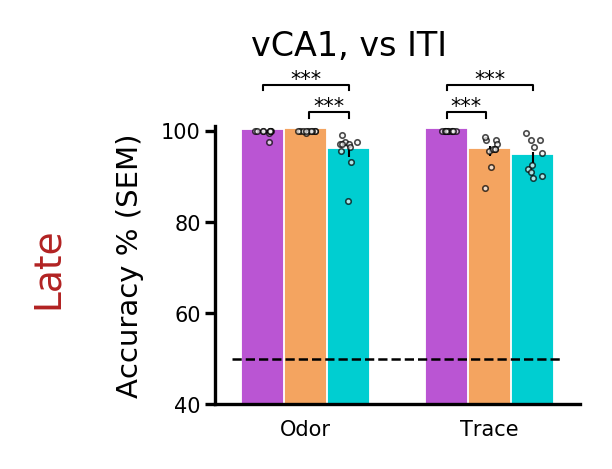

In [120]:
from matplotlib.patches import Patch
labels = ['Odor','Trace']
x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars
loops=10
to_plot = [0,1]
tb='1s'
fig, ax = pl.subplots(figsize=(1.9,1.4))

for comp,c,la,wide in zip(['consumed','run_AA','run_CSm'],['mediumorchid','sandybrown','darkturquoise'],
                     ['Reward','Avoided Sh','CS-'],[-width/3-.25,0,width/3+.25,0.5+.2]):
    ste = np.array(np.std(eval("baseline_scores_gmin_%s_3_%s_vhpc['post'][-loops:]"%(tb,comp)))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("baseline_scores_gmin_%s_3_%s_vhpc['post'][-loops:]"%(tb,comp)))*100,
           width, edgecolor=c,color=c,yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, eval("baseline_scores_gmin_%s_3_%s_vhpc['post'][-loops:]"%(tb,comp))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
    
for comp,c,la,wide in zip(['consumed','run_AA','run_CSm'],['mediumorchid','sandybrown','darkturquoise'],
                     ['Reward','Avoided Sh','CS-'],[1.5+-width/3-.25,1.5+0,1.5+width/3+.25,1.5+0.5+.2]):
    ste = np.array(np.std(eval("baseline_scores_gmin_%s_6_%s_vhpc['post'][-loops:]"%(tb,comp)))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("baseline_scores_gmin_%s_6_%s_vhpc['post'][-loops:]"%(tb,comp)))*100,
           width, edgecolor=c,color=c,yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, eval("baseline_scores_gmin_%s_6_%s_vhpc['post'][-loops:]"%(tb,comp))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')

ax.hlines(50,-.6,2.1, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)')
#ax.set_title('Decoding During CS')
ax.set_ylim(40,101)
ax.set_xticks([0,1.5])
ax.set_xticklabels(labels)
#ax.legend([Patch(facecolor='darkorchid'),Patch(facecolor='sandybrown'),Patch(facecolor='darkturquoise')],
#          ['Rew','Shock','CS-'],loc=(.95,.6),frameon=False)
#ax.text(2.8,92,'Rew',color='mediumorchid',fontsize=5.5)
#ax.text(2.8,80,'CS-',color='darkturquoise',fontsize=5.5)
#ax.text(2.8,86,'Avoided Shock',color='sandybrown',fontsize=5.5)
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
pvs=[]
test='ttest'
for t,i in zip([3,6], [0,1.5]):
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_consumed_vhpc['post'][-loops:]"%(tb,t)),
                                eval("baseline_scores_gmin_%s_%s_run_AA_vhpc['post'][-loops:]"%(tb,t)),
                                -width/3-.25+i,i-.03,104,mcc=2))
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_run_CSm_vhpc['post'][-loops:]"%(tb,t)),
                                eval("baseline_scores_gmin_%s_%s_run_AA_vhpc['post'][-loops:]"%(tb,t)),
        i+.03,width/3+.25+i,104,mcc=2))
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_consumed_vhpc['post'][-loops:]"%(tb,t)),
                                eval("baseline_scores_gmin_%s_%s_run_CSm_vhpc['post'][-loops:]"%(tb,t)),
        -width/3-.25+i,width/3+.25+i,110,mcc=2))
    print 'rw/sh',report_stats(eval("baseline_scores_gmin_1s_%s_consumed_vhpc['post'][-loops:]"%t), eval("baseline_scores_gmin_1s_%s_run_AA_vhpc['post'][-loops:]"%t),mcc=2)
    print 'sh/CS-',report_stats(eval("baseline_scores_gmin_1s_%s_run_AA_vhpc['post'][-loops:]"%t), eval("baseline_scores_gmin_1s_%s_run_CSm_vhpc['post'][-loops:]"%t),mcc=2)
    print 'rw/CS-',report_stats(eval("baseline_scores_gmin_1s_%s_consumed_vhpc['post'][-loops:]"%t), eval("baseline_scores_gmin_1s_%s_run_CSm_vhpc['post'][-loops:]"%t),mcc=2)

pl.suptitle('vCA1, vs ITI',y=1.1,fontsize=8)
ax.text(-2.1,70,'Late',rotation=90,fontsize=9,color='firebrick',ha='center',va='center')
fig.tight_layout(pad=2.5)

fig.savefig('../figures/%s_bars_vhpc.pdf'%NOTEBOOK_NAME)

rw/sh U = 20.5 p = 0.0488370104195 r = -0.49864101029
None
sh/CS- U = 65.5 p = 0.473666427097 r = 0.261997818966
None
rw/CS- U = 36.5 p = 0.641950063079 r = -0.228191648777
None
rw/sh U = 40.0 p = 0.928307639643 r = -0.169030850946
None
sh/CS- U = 81.5 p = 0.0354631057849 r = 0.532447180479
None
rw/CS- U = 76.0 p = 0.104924968256 r = 0.439480212459
None


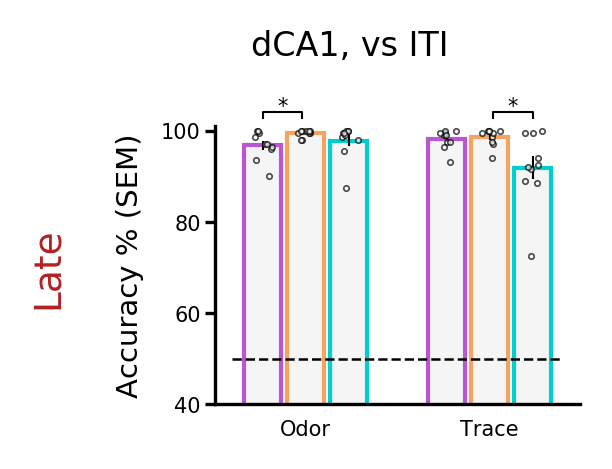

In [121]:
from matplotlib.patches import Patch
labels = ['Odor','Trace']
x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars
loops=10
to_plot = [0,1]
t=3
tb='1s'
fig, ax = pl.subplots(figsize=(1.9,1.4))

for comp,c,la,wide in zip(['consumed','run_AA','run_CSm'],['mediumorchid','sandybrown','darkturquoise'],
                     ['Reward','Avoided Sh','CS-'],[-width/3-.25,0,width/3+.25,0.5+.2]):
    ste = np.array(np.std(eval("baseline_scores_gmin_%s_3_%s_dhpc['post'][-loops:]"%(tb,comp)))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("baseline_scores_gmin_%s_3_%s_dhpc['post'][-loops:]"%(tb,comp)))*100,
           width, edgecolor=c,color='whitesmoke',yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, eval("baseline_scores_gmin_%s_3_%s_dhpc['post'][-loops:]"%(tb,comp))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
    
for comp,c,la,wide in zip(['consumed','run_AA','run_CSm'],['mediumorchid','sandybrown','darkturquoise'],
                     ['Reward','Avoided Sh','CS-'],[1.5+-width/3-.25,1.5+0,1.5+width/3+.25,1.5+0.5+.2]):
    ste = np.array(np.std(eval("baseline_scores_gmin_%s_6_%s_dhpc['post'][-loops:]"%(tb,comp)))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("baseline_scores_gmin_%s_6_%s_dhpc['post'][-loops:]"%(tb,comp)))*100,
           width, edgecolor=c,color='whitesmoke',yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, eval("baseline_scores_gmin_%s_6_%s_dhpc['post'][-loops:]"%(tb,comp))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')

ax.hlines(50,-.6,2.1, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)')
#ax.set_title('Decoding During CS')
ax.set_ylim(40,101)
ax.set_xticks([0,1.5])
ax.set_xticklabels(labels)
#ax.legend([Patch(facecolor='darkorchid'),Patch(facecolor='sandybrown'),Patch(facecolor='darkturquoise')],
#          ['Rew','Shock','CS-'],loc=(.95,.6),frameon=False)
#ax.text(2.8,92,'Rew',color='mediumorchid',fontsize=5.5)
#ax.text(2.8,80,'CS-',color='darkturquoise',fontsize=5.5)
#ax.text(2.8,86,'Avoided Shock',color='sandybrown',fontsize=5.5)
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
pvs=[]
test='ttest'
for t,i in zip([3,6], [0,1.5]):
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_consumed_dhpc['post'][-loops:]"%(tb,t)),
                                eval("baseline_scores_gmin_%s_%s_run_AA_dhpc['post'][-loops:]"%(tb,t)),
                                -width/3-.25+i,i-.03,104,mcc=2))
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_run_CSm_dhpc['post'][-loops:]"%(tb,t)),
                                eval("baseline_scores_gmin_%s_%s_run_AA_dhpc['post'][-loops:]"%(tb,t)),
        i+.03,width/3+.25+i,104,mcc=2))
    pvs.append(add_significance(ax,eval("baseline_scores_gmin_%s_%s_consumed_dhpc['post'][-loops:]"%(tb,t)),
                                eval("baseline_scores_gmin_%s_%s_run_CSm_dhpc['post'][-loops:]"%(tb,t)),
        -width/3-.25+i,width/3+.25+i,110,mcc=2))
    print 'rw/sh',report_stats(eval("baseline_scores_gmin_1s_%s_consumed_dhpc['post'][-loops:]"%t), eval("baseline_scores_gmin_1s_%s_run_AA_dhpc['post'][-loops:]"%t),mcc=2)
    print 'sh/CS-',report_stats(eval("baseline_scores_gmin_1s_%s_run_AA_dhpc['post'][-loops:]"%t), eval("baseline_scores_gmin_1s_%s_run_CSm_dhpc['post'][-loops:]"%t),mcc=2)
    print 'rw/CS-',report_stats(eval("baseline_scores_gmin_1s_%s_consumed_dhpc['post'][-loops:]"%t), eval("baseline_scores_gmin_1s_%s_run_CSm_dhpc['post'][-loops:]"%t),mcc=2)

pl.suptitle('dCA1, vs ITI',y=1.1,fontsize=8)
ax.text(-2.1,70,'Late',rotation=90,fontsize=9,color='firebrick',ha='center',va='center')
fig.tight_layout(pad=2.5)

fig.savefig('../figures/%s_bars_dhpc.pdf'%NOTEBOOK_NAME)

In [41]:
save_workspace(db)

Could not store variable 'IPython'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'np'. Skipping...
